In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
import psycopg2

ubuntu=True

con = None

if ubuntu: 
    con = psycopg2.connect(database='mountainproject', password='kepler31', user='devin', port=5432, host='/var/run/postgresql/')
else:
    con = psycopg2.connect(database='mountainproject', user='User')
cur = con.cursor()
con.autocommit = True

#Get raw data together

In [2]:
data_set = 'star5'
df_obs = pd.read_csv(data_set+'_observed_features.csv')
df_obs = df_obs.set_index('Climb')

In [3]:
q= '''
    SELECT climb_id, comment
    FROM comments;
    '''
cur.execute(q)
df_com = pd.DataFrame(cur.fetchall())
df_com.columns = ['climb_id', 'comment']
df_com.head()

comments_series = df_com.groupby(df_com.climb_id)['comment'].agg(lambda col: ' '.join(col))
comments_count = df_com.groupby(df_com.climb_id).count()
df_raw = df_obs.join(comments_series).join(comments_count, rsuffix='_count')
df_raw.head()

,location,rating,rating_dif,star_votes,stars,sub_location,type,comment,comment_count
Climb,,,,,,,,,
105834134,Utah,22.75,0.0,6,3.5,Wasatch Range,Trad,Neat route. Roof on p2 is fantastically unbel...,15
106181256,Colorado,19.50,1.5,12,3.1,Boulder,Trad,Was this climb retro-bolted? I climbed a rout...,2
105920111,International,17.50,0.0,13,2.9,North America,Sport,NaN,NaN
106208618,California,13.00,0.0,24,3.1,Yosemite National Park,Trad,This climb had runouts of similar (or longer) ...,3
105718117,Utah,28.00,0.5,45,4.9,Zion National Park,Sport,These are incredible sport routes a must do fo...,23


##TFIDF on comments

In [4]:
n_samples = 2000
n_features = 1000
n_topics = 4
n_top_words = 10
df_comment = pd.DataFrame(df_raw.comment).fillna('')
comment_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, max_features=n_features,
                             stop_words='english')
comment_tfidf = comment_vectorizer.fit_transform(df_comment.comment)

In [5]:
com_train, com_test, y_train, y_test = train_test_split(comment_tfidf, 
                                                        df_raw.stars, 
                                                        test_size=0.2, 
                                                        random_state=42 )

In [6]:
com_clas = RandomForestRegressor(n_estimators=200,
                                n_jobs=-1).fit(com_train, 
                                                y_train,)

In [7]:
com_y_pred = com_clas.predict(com_test)

print "MAE:", mean_absolute_error(y_test, com_y_pred)
print "MSE:", mean_squared_error(y_test, com_y_pred)
y_std = np.std(df_raw.stars)
print y_std

MAE: 0.513953590628
MSE: 0.408372309433
0.710885256361


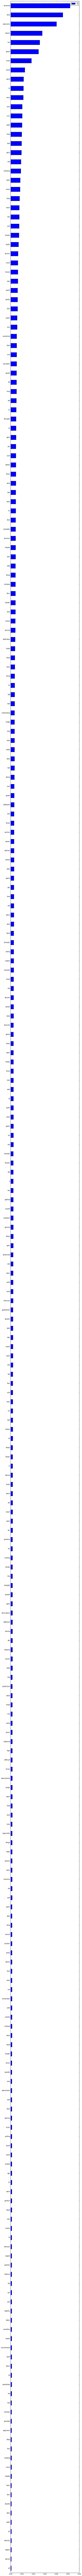

In [8]:
n_words = 20
features = comment_vectorizer.get_feature_names()
feature_df = pd.DataFrame(com_clas.feature_importances_, index=features)
feature_df.sort(0, inplace=True)
# plt.figure(figsize=(20,20))
feature_df.plot(kind="barh", figsize=(8,300))
plt.show()

In [9]:
#Make new tfidf prediction dataframe
df_tfidf_pred = pd.DataFrame(
    com_clas.predict(
    comment_vectorizer.transform(df_comment.comment)
    )
    ).set_index(df_comment.index)
df_tfidf_pred.columns=['tf_score']

In [10]:
df_tfidf_pred.head()

,tf_score
Climb,
105834134,4.108000
106181256,3.212000
105920111,3.437179
106208618,3.218000
105718117,4.755000


##Dummify and drop catagorical columns.

In [11]:
def dummify(df, col_names, drop_cols):
    
    for col_name in col_names:
        df = pd.concat([df, pd.get_dummies(df[col_name])], axis = 1).drop(col_name,1)
    for col in drop_cols:
        df=df.drop(col, 1)
    
    return df


In [13]:
df_raw.columns

Index([u'location', u'rating', u'rating_dif', u'star_votes', u'stars',
       u'sub_location', u'type', u'comment', u'comment_count'],
      dtype='object')

In [14]:
to_dum = ('type', 'sub_location')
to_drop = ['comment', 'location']

df = pd.concat([dummify(df_raw, to_dum, to_drop), df_tfidf_pred],
               axis=1)
df.head()

,rating,rating_dif,star_votes,stars,comment_count,Sport,TR,Trad,*NH Ice and Alpine Climbing,Acadia National Park,...,West Point,White Ledge (Albany),White's Ledge,Whitehorse Ledge,Wild River Crags (aka Evans Notch),Willamette Valley,Wind River Range,Yosemite National Park,Zion National Park,tf_score
Climb,,,,,,,,,,,,,,,,,,,,,
105834134,22.75,0.0,6,3.5,15,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.108000
106181256,19.50,1.5,12,3.1,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.212000
105920111,17.50,0.0,13,2.9,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.437179
106208618,13.00,0.0,24,3.1,3,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3.218000
105718117,28.00,0.5,45,4.9,23,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.755000


In [15]:
targ = 'stars'
y = df[targ]
X = df.drop(targ, 1).fillna(0)

In [16]:
clas = RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [18]:
clas.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
clas.transform(X).shape

(13675, 5)

In [20]:
y_pred = clas.predict(X_test)

print mean_absolute_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred)

0.48168345917
0.377260265171


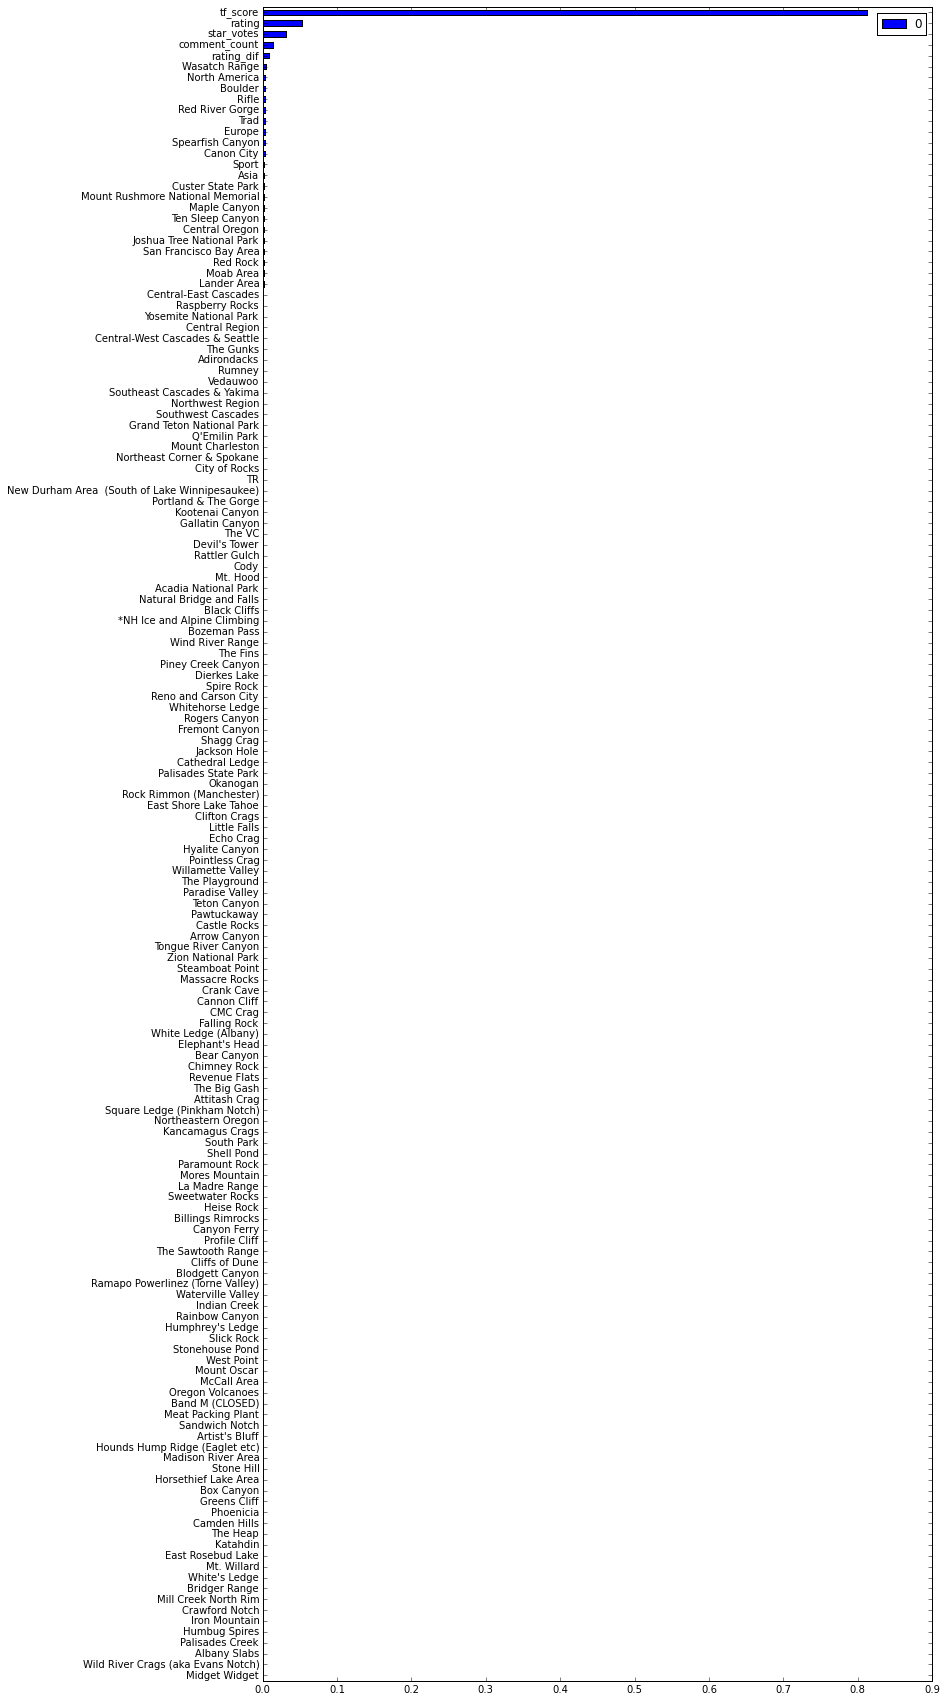

In [21]:
features = X.columns
feature_df = pd.DataFrame(clas.feature_importances_, index=features)
feature_df.sort(0, inplace=True)
# plt.figure(figsize=(20,20))
feature_df.plot(kind="barh", figsize=(12,30))
plt.show()

##Make a sample case

In [22]:
df.head()

,rating,rating_dif,star_votes,stars,comment_count,Sport,TR,Trad,*NH Ice and Alpine Climbing,Acadia National Park,...,West Point,White Ledge (Albany),White's Ledge,Whitehorse Ledge,Wild River Crags (aka Evans Notch),Willamette Valley,Wind River Range,Yosemite National Park,Zion National Park,tf_score
Climb,,,,,,,,,,,,,,,,,,,,,
105834134,22.75,0.0,6,3.5,15,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.108000
106181256,19.50,1.5,12,3.1,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.212000
105920111,17.50,0.0,13,2.9,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.437179
106208618,13.00,0.0,24,3.1,3,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3.218000
105718117,28.00,0.5,45,4.9,23,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.755000


In [23]:


df_raw.head()

,location,rating,rating_dif,star_votes,stars,sub_location,type,comment,comment_count
Climb,,,,,,,,,
105834134,Utah,22.75,0.0,6,3.5,Wasatch Range,Trad,Neat route. Roof on p2 is fantastically unbel...,15
106181256,Colorado,19.50,1.5,12,3.1,Boulder,Trad,Was this climb retro-bolted? I climbed a rout...,2
105920111,International,17.50,0.0,13,2.9,North America,Sport,NaN,NaN
106208618,California,13.00,0.0,24,3.1,Yosemite National Park,Trad,This climb had runouts of similar (or longer) ...,3
105718117,Utah,28.00,0.5,45,4.9,Zion National Park,Sport,These are incredible sport routes a must do fo...,23


In [24]:
climb_ave = ((df.loc[106181256]+df.iloc[4])/2 ).drop('stars')
climb_ave

rating                                23.7500
rating_dif                             1.0000
star_votes                            28.5000
comment_count                         12.5000
Sport                                  0.5000
TR                                     0.0000
Trad                                   0.5000
*NH Ice and Alpine Climbing            0.0000
Acadia National Park                   0.0000
Adirondacks                            0.0000
Albany Slabs                           0.0000
Arrow Canyon                           0.0000
Artist's Bluff                         0.0000
Asia                                   0.0000
Attitash Crag                          0.0000
Band M (CLOSED)                        0.0000
Bear Canyon                            0.0000
Billings Rimrocks                      0.0000
Black Cliffs                           0.0000
Blodgett Canyon                        0.0000
Boulder                                0.5000
Box Canyon                        

In [25]:
clas.predict(climb_ave)

array([ 4.022])

In [29]:
climb_ave['Boulder'] = 0
climb_ave['Zion National Park'] = 0
climb_ave['Wasatch Range'] = 1

In [30]:
clas.predict(climb_ave)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
    ...........................................................................
/home/devin/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='IPython.kernel.__main__', alter_argv=1)
    157     pkg_name = mod_name.rpartition('.')[0]
    158     main_globals = sys.modules["__main__"].__dict__
    159     if alter_argv:
    160         sys.argv[0] = fname
    161     return _run_code(code, main_globals, None,
--> 162                      "__main__", fname, loader, pkg_name)
        fname = '/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'IPython.kernel'
    163 
    164 def run_module(mod_name, init_globals=None,
    165                run_name=None, alter_sys=False):
    166     """Execute a module's code without importing it

...........................................................................
/home/devin/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7fa0dc207730, file "/...ite-packages/IPython/kernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/ho.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='IPython.kernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7fa0dc207730, file "/...ite-packages/IPython/kernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/ho.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from IPython.kernel.zmq import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/config/application.py in launch_instance(cls=<class 'IPython.kernel.zmq.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    569         
    570         If a global instance already exists, this reinitializes and starts it
    571         """
    572         app = cls.instance(**kwargs)
    573         app.initialize(argv)
--> 574         app.start()
        app.start = <bound method IPKernelApp.start of <IPython.kernel.zmq.kernelapp.IPKernelApp object>>
    575 
    576 #-----------------------------------------------------------------------------
    577 # utility functions, for convenience
    578 #-----------------------------------------------------------------------------

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelapp.py in start(self=<IPython.kernel.zmq.kernelapp.IPKernelApp object>)
    368     def start(self):
    369         if self.poller is not None:
    370             self.poller.start()
    371         self.kernel.start()
    372         try:
--> 373             ioloop.IOLoop.instance().start()
    374         except KeyboardInterrupt:
    375             pass
    376 
    377 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    861                 self._events.update(event_pairs)
    862                 while self._events:
    863                     fd, events = self._events.popitem()
    864                     try:
    865                         fd_obj, handler_func = self._handlers[fd]
--> 866                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    867                     except (OSError, IOError) as e:
    868                         if errno_from_exception(e) == errno.EPIPE:
    869                             # Happens when the client closes the connection
    870                             pass

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    247         if self.control_stream:
    248             self.control_stream.on_recv(self.dispatch_control, copy=False)
    249 
    250         def make_dispatcher(stream):
    251             def dispatcher(msg):
--> 252                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    253             return dispatcher
    254 
    255         for s in self.shell_streams:
    256             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatch_shell(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'clas.predict(climb_ave)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'832BED80255C44C4845919B689400F3A', u'msg_type': u'execute_request', u'session': u'70726ED72FE741FBBB63BB89F3B6F58C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'832BED80255C44C4845919B689400F3A', 'msg_type': u'execute_request', 'parent_header': {}})
    208         else:
    209             # ensure default_int_handler during handler call
    210             sig = signal(SIGINT, default_int_handler)
    211             self.log.debug("%s: %s", msg_type, msg)
    212             try:
--> 213                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <IPython.kernel.zmq.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['70726ED72FE741FBBB63BB89F3B6F58C']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'clas.predict(climb_ave)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'832BED80255C44C4845919B689400F3A', u'msg_type': u'execute_request', u'session': u'70726ED72FE741FBBB63BB89F3B6F58C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'832BED80255C44C4845919B689400F3A', 'msg_type': u'execute_request', 'parent_header': {}}
    214             except Exception:
    215                 self.log.error("Exception in message handler:", exc_info=True)
    216             finally:
    217                 signal(SIGINT, sig)

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in execute_request(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['70726ED72FE741FBBB63BB89F3B6F58C'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'clas.predict(climb_ave)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'832BED80255C44C4845919B689400F3A', u'msg_type': u'execute_request', u'session': u'70726ED72FE741FBBB63BB89F3B6F58C', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'832BED80255C44C4845919B689400F3A', 'msg_type': u'execute_request', 'parent_header': {}})
    357         if not silent:
    358             self.execution_count += 1
    359             self._publish_execute_input(code, parent, self.execution_count)
    360         
    361         reply_content = self.do_execute(code, silent, store_history,
--> 362                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    363 
    364         # Flush output before sending the reply.
    365         sys.stdout.flush()
    366         sys.stderr.flush()

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/ipkernel.py in do_execute(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, code=u'clas.predict(climb_ave)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    176 
    177         reply_content = {}
    178         # FIXME: the shell calls the exception handler itself.
    179         shell._reply_content = None
    180         try:
--> 181             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = u'clas.predict(climb_ave)'
        store_history = True
        silent = False
    182         except:
    183             status = u'error'
    184             # FIXME: this code right now isn't being used yet by default,
    185             # because the run_cell() call above directly fires off exception

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, raw_cell=u'clas.predict(climb_ave)', store_history=True, silent=False, shell_futures=True)
   2866                 self.displayhook.exec_result = result
   2867 
   2868                 # Execute the user code
   2869                 interactivity = "none" if silent else self.ast_node_interactivity
   2870                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2871                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2872 
   2873                 # Reset this so later displayed values do not modify the
   2874                 # ExecutionResult
   2875                 self.displayhook.exec_result = None

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-30-935e6bfcef52>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2976                     return True
   2977 
   2978             for i, node in enumerate(to_run_interactive):
   2979                 mod = ast.Interactive([node])
   2980                 code = compiler(mod, cell_name, "single")
-> 2981                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fa0a3a23e30, file "<ipython-input-30-935e6bfcef52>", line 1>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2982                     return True
   2983 
   2984             # Flush softspace
   2985             if softspace(sys.stdout, 0):

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fa0a3a23e30, file "<ipython-input-30-935e6bfcef52>", line 1>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3030         outflag = 1  # happens in more places, so it's easier as default
   3031         try:
   3032             try:
   3033                 self.hooks.pre_run_code_hook()
   3034                 #rprint('Running code', repr(code_obj)) # dbg
-> 3035                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fa0a3a23e30, file "<ipython-input-30-935e6bfcef52>", line 1>
        self.user_global_ns = {'In': ['', u"import matplotlib.pyplot as plt\nget_ipython()...ser')\ncur = con.cursor()\ncon.autocommit = True", u"data_set = 'star5'\ndf_obs = pd.read_csv(data_...atures.csv')\ndf_obs = df_obs.set_index('Climb')", u"q= '''\n    SELECT climb_id, comment\n    FROM...comments_count, rsuffix='_count')\ndf_raw.head()", u"n_samples = 2000\nn_features = 1000\nn_topics ...ent_vectorizer.fit_transform(df_comment.comment)", u'com_train, com_test, y_train, y_test = train_t...                               random_state=42 )', u'com_clas = RandomForestRegressor(n_estimators=...                                       y_train,)', u'com_y_pred = com_clas.predict(com_test)\n\npri...pred)\ny_std = np.std(df_raw.stars)\nprint y_std', u'n_words = 20\nfeatures = comment_vectorizer.ge...f.plot(kind="barh", figsize=(8,300))\nplt.show()', u"#Make new tfidf prediction dataframe\ndf_tfidf...mment.index)\ndf_tfidf_pred.columns=['tf_score']", u'df_tfidf_pred.head()', u'def dummify(df, col_names, drop_cols):\n    \n...n        df=df.drop(col, 1)\n    \n    return df', u"to_dum = ('location', 'type', 'sub_location')\..._tfidf_pred],\n               axis=1)\ndf.head()", u'df_raw.columns', u"to_dum = ('type', 'sub_location')\nto_drop = [..._tfidf_pred],\n               axis=1)\ndf.head()", u"targ = 'stars'\ny = df[targ]\nX = df.drop(targ, 1).fillna(0)", u'clas = RandomForestRegressor(n_estimators=200, n_jobs=-1)', u'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )', u'clas.fit(X_train, y_train)', u'clas.transform(X).shape', ...], 'Out': {3:                 location  rating  rating_dif  st...ble sport routes a must do fo...             23  , 10:            tf_score
Climb              
10583413... 3.437179
106208618  3.218000
105718117  4.755000, 13: Index([u'location', u'rating', u'rating_dif', u'...omment', u'comment_count'],
      dtype='object'), 14:            rating  rating_dif  star_votes  stars...0  
105718117  4.755000  

[5 rows x 155 columns], 18: RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), 19: (13675, 5), 22:            rating  rating_dif  star_votes  stars...0  
105718117  4.755000  

[5 rows x 155 columns], 23:                 location  rating  rating_dif  st...ble sport routes a must do fo...             23  , 24: rating                                23.7500
ra...                            1.0000
dtype: float64, 25: array([ 4.022])}, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X':            rating  rating_dif  star_votes  comme...        0  3.437179  

[13675 rows x 154 columns], 'X_test':            rating  rating_dif  star_votes  comme...         0  3.437179  

[2735 rows x 154 columns], 'X_train':            rating  rating_dif  star_votes  comme...        0  4.057000  

[10940 rows x 154 columns], '_': array([ 4.022]), '_10':            tf_score
Climb              
10583413... 3.437179
106208618  3.218000
105718117  4.755000, '_13': Index([u'location', u'rating', u'rating_dif', u'...omment', u'comment_count'],
      dtype='object'), ...}
        self.user_ns = {'In': ['', u"import matplotlib.pyplot as plt\nget_ipython()...ser')\ncur = con.cursor()\ncon.autocommit = True", u"data_set = 'star5'\ndf_obs = pd.read_csv(data_...atures.csv')\ndf_obs = df_obs.set_index('Climb')", u"q= '''\n    SELECT climb_id, comment\n    FROM...comments_count, rsuffix='_count')\ndf_raw.head()", u"n_samples = 2000\nn_features = 1000\nn_topics ...ent_vectorizer.fit_transform(df_comment.comment)", u'com_train, com_test, y_train, y_test = train_t...                               random_state=42 )', u'com_clas = RandomForestRegressor(n_estimators=...                                       y_train,)', u'com_y_pred = com_clas.predict(com_test)\n\npri...pred)\ny_std = np.std(df_raw.stars)\nprint y_std', u'n_words = 20\nfeatures = comment_vectorizer.ge...f.plot(kind="barh", figsize=(8,300))\nplt.show()', u"#Make new tfidf prediction dataframe\ndf_tfidf...mment.index)\ndf_tfidf_pred.columns=['tf_score']", u'df_tfidf_pred.head()', u'def dummify(df, col_names, drop_cols):\n    \n...n        df=df.drop(col, 1)\n    \n    return df', u"to_dum = ('location', 'type', 'sub_location')\..._tfidf_pred],\n               axis=1)\ndf.head()", u'df_raw.columns', u"to_dum = ('type', 'sub_location')\nto_drop = [..._tfidf_pred],\n               axis=1)\ndf.head()", u"targ = 'stars'\ny = df[targ]\nX = df.drop(targ, 1).fillna(0)", u'clas = RandomForestRegressor(n_estimators=200, n_jobs=-1)', u'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )', u'clas.fit(X_train, y_train)', u'clas.transform(X).shape', ...], 'Out': {3:                 location  rating  rating_dif  st...ble sport routes a must do fo...             23  , 10:            tf_score
Climb              
10583413... 3.437179
106208618  3.218000
105718117  4.755000, 13: Index([u'location', u'rating', u'rating_dif', u'...omment', u'comment_count'],
      dtype='object'), 14:            rating  rating_dif  star_votes  stars...0  
105718117  4.755000  

[5 rows x 155 columns], 18: RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), 19: (13675, 5), 22:            rating  rating_dif  star_votes  stars...0  
105718117  4.755000  

[5 rows x 155 columns], 23:                 location  rating  rating_dif  st...ble sport routes a must do fo...             23  , 24: rating                                23.7500
ra...                            1.0000
dtype: float64, 25: array([ 4.022])}, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X':            rating  rating_dif  star_votes  comme...        0  3.437179  

[13675 rows x 154 columns], 'X_test':            rating  rating_dif  star_votes  comme...         0  3.437179  

[2735 rows x 154 columns], 'X_train':            rating  rating_dif  star_votes  comme...        0  4.057000  

[10940 rows x 154 columns], '_': array([ 4.022]), '_10':            tf_score
Climb              
10583413... 3.437179
106208618  3.218000
105718117  4.755000, '_13': Index([u'location', u'rating', u'rating_dif', u'...omment', u'comment_count'],
      dtype='object'), ...}
   3036             finally:
   3037                 # Reset our crash handler in place
   3038                 sys.excepthook = old_excepthook
   3039         except SystemExit as e:

...........................................................................
/home/devin/Capstone/<ipython-input-30-935e6bfcef52> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 clas.predict(climb_ave)
      7 
      8 
      9 
     10 

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py in predict(self=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=array([[ 23.75  ,   1.    ,  28.5   ,  12.5   , ...5,   0.    ,   0.    ,   1.    ]], dtype=float32))
    626 
    627         # Parallel loop
    628         all_y_hat = Parallel(n_jobs=n_jobs, verbose=self.verbose,
    629                              backend="threading")(
    630             delayed(_parallel_helper)(e, 'predict', X, check_input=False)
--> 631             for e in self.estimators_)
        self.estimators_ = [DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=649105484,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=712374781,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=1890417555,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=607128552,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=2120897918,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=266538145,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=986946170,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=1692490886,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=2089839864,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=1985088822,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=709180081,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=2117701149,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...andom_state=11205749,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=201985392,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=500970975,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=1465960566,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=1875068551,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=2025415213,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=867284085,
           splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth...dom_state=1998012868,
           splitter='best'), ...]
    632 
    633         # Reduce
    634         y_hat = sum(all_y_hat) / len(self.estimators_)
    635 

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object <genexpr>>)
    661             if pre_dispatch == "all" or n_jobs == 1:
    662                 # The iterable was consumed all at once by the above for loop.
    663                 # No need to wait for async callbacks to trigger to
    664                 # consumption.
    665                 self._iterating = False
--> 666             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    667             # Make sure that we get a last message telling us we are done
    668             elapsed_time = time.time() - self._start_time
    669             self._print('Done %3i out of %3i | elapsed: %s finished',
    670                         (len(self._output),

    ---------------------------------------------------------------------------
    Sub-process traceback:
    ---------------------------------------------------------------------------
    ValueError                                         Thu Aug  6 22:13:50 2015
PID: 13854                   Python 2.7.10: /home/devin/anaconda/bin/python
...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.pyc in _parallel_helper(obj=DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=649105484,
           splitter='best'), methodname='predict', *args=(array([[ 23.75  ,   1.    ,  28.5   ,  12.5   , ...5,   0.    ,   0.    ,   1.    ]], dtype=float32),), **kwargs={'check_input': False})
    101     return tree
    102 
    103 
    104 def _parallel_helper(obj, methodname, *args, **kwargs):
    105     """Private helper to workaround Python 2 pickle limitations"""
--> 106     return getattr(obj, methodname)(*args, **kwargs)
    107 
    108 
    109 class BaseForest(six.with_metaclass(ABCMeta, BaseEnsemble,
    110                                     _LearntSelectorMixin)):

...........................................................................
/home/devin/anaconda/lib/python2.7/site-packages/sklearn/tree/tree.pyc in predict(self=DecisionTreeRegressor(criterion='mse', max_depth...ndom_state=649105484,
           splitter='best'), X=array([[ 23.75  ,   1.    ,  28.5   ,  12.5   , ...5,   0.    ,   0.    ,   1.    ]], dtype=float32), check_input=False)
    346 
    347         if self.n_features_ != n_features:
    348             raise ValueError("Number of features of the model must "
    349                              " match the input. Model n_features is %s and "
    350                              " input n_features is %s "
--> 351                              % (self.n_features_, n_features))
    352 
    353         proba = self.tree_.predict(X)
    354 
    355         # Classification

ValueError: Number of features of the model must  match the input. Model n_features is 154 and  input n_features is 157 
___________________________________________________________________________